<font size="8"> **Calculating distance to shelf break** </font>  
The continental shelf is often defined as the 1,000 m depth contour. The closest depth in the ACCESS-OM2-01 model grid is 1,017 metres, so we will be using this as the depth contour that defines the continental shelf around Antarctica. We will use `temperature`, a three dimensional output, for a single month, from which we will identify the location of the continental shelf break.
  
In this notebook, we will create a base contour line for the shelf break (1,017 metre depth), which will have a point at the centre of each grid. This base contour line will be post-processed in QGIS to extract a single line representing the continental shelf surrounding Antarctica. In other words, any additional areas with a depth of 1,017 meters will be removed manually from the base contour line produced here.  
  
Finally, we will load the corrected contour line for the shelf and calculate the distance from every grid cell in our original data to the closest point along the shelf break.  
  
**Note:** A copy of the corrected contour line along the shelf is provided in this repository.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [2]:
#Accessing model data
import cosima_cookbook as cc
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Useful package to deal with file paths
from glob import glob
#Parallelising work
from dask.distributed import Client
#Spatial analysis (extracting contour lines)
import rioxarray
from osgeo import osr
from osgeo import ogr
from osgeo import gdal
import geopandas as gp
from shapely.geometry import Point
from sklearn.neighbors import BallTree

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [3]:
varDict = {'var_mod': 'temp',
           'model': 'ACCESS-OM2-01',
           'exp': '01deg_jra55v140_iaf_cycle4',
           'freq': '1 monthly',
           'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables'}

# Creating a session in the COSIMA cookbook

In [4]:
session = cc.database.create_session()

# Accessing ACCESS-OM2-01 data
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [4]:
client = Client()
client

2023-05-01 15:22:07,841 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/82314268.gadi-pbs/dask-worker-space/worker-8wccxbxu', purging
2023-05-01 15:22:07,842 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/82314268.gadi-pbs/dask-worker-space/worker-jfqd98kx', purging
2023-05-01 15:22:07,842 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/82314268.gadi-pbs/dask-worker-space/worker-5scclqg6', purging
2023-05-01 15:22:07,842 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/82314268.gadi-pbs/dask-worker-space/worker-vky7nvab', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41715/status,
Dashboard: /proxy/41715/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37697,Workers: 4
Dashboard: /proxy/41715/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33017,Total threads: 2
Dashboard: /proxy/38755/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:45703,


We will now access a single monthly output for conservation temperature, `temp` for short, from the fourth cycle of ACCESS-OM2-01 (`01deg_jra55v140_iaf_cycle4`). This will give us access to a depth bins, so we can identify the continental shelf break (1,017 depth contour).

In [6]:
#Loading mean temperature data for a single month
temp = cc.querying.getvar(varDict['exp'], varDict['var_mod'], session, frequency = varDict['freq'], n = 1)
#Extracting data for the Southern Ocean only
temp = temp.sel(yt_ocean = slice(-90, -45))

# Extracting data at reference depth to identify continental shelf

Next, we will extract the grid cells for the contour of our interest. This will a data array where grid cells with temperature values represent grid cells with a depth over 1,017 m and any grid cells with `NaN` represent areas where land mass is present at that depth. Values of `1` are then assigned to any grid cells where water is present at the surface, and a value of `2` is given to any other areas that are deeper. A land mask is also applied based on the surface layer. Finally, to remove any continental shelf areas away from Antarctica, any grid cells from latitude $58^{\circ}S$ will also be given a value of `2`.

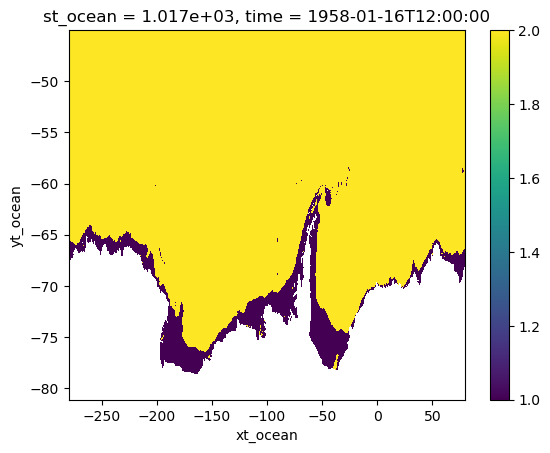

In [31]:
#Extract contour at reference depth (1017 m)
cont_1000 = temp.sel(st_ocean = slice(1000, 1100))
#Assigning new values and applying land mask
cont_1000 = xr.where(~np.isnan(cont_1000), 2, 1).where(~np.isnan(temp.isel(st_ocean = 0)), np.nan)
cont_1000 = xr.where(cont_1000.yt_ocean > -58, 2, cont_1000)
#Checking result
cont_1000.plot()

In the figure above, the continental shelf is represented by the boundary between the purple and yellow areas surrounding the Antarctic continent.  

# Saving data 
Before we can extract the contour of our interest, we need to assign a coordinate reference system (CRS) to our new data array and save it in `tif` format.

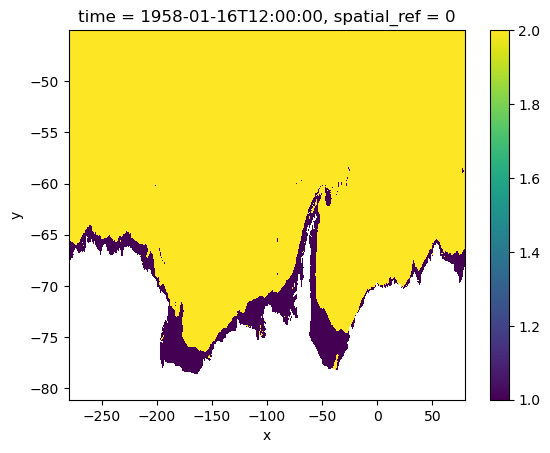

In [32]:
#Assign CRS - EPSG 4326 uses coordinates and its datum is WGS84.
cont_1000.rio.write_crs('epsg:4326', inplace = True)
#Renaming x and y axes so file can be recognised by spatial processing libraries
cont_1000 = cont_1000.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
#Removing the depth (st_ocean) dimension as we no longer need this information
cont_1000 = cont_1000.squeeze(('st_ocean')).drop(('st_ocean'))
#Rearranging dimensions
cont_1000 = cont_1000.transpose('time', 'y', 'x')
#Checking result - It should match the plot above 
cont_1000.plot()

In [ ]:
#Ensuring folder where outputs will be saved exists
os.makedirs(varDict['base_folder'], exist_ok = True)

#Saving our data array as tif
cont_1000.rio.to_raster(os.path.join(varDict['base_folder'], 'Shelf_Contour_Mask.tif'))

# Identifying contour for continental shelf
For this section, we will use the `gdal` package for spatial analysis.

## Load `tif` file

In [34]:
#Load raster
raster = gdal.Open(os.path.join(varDict['base_folder'], 'Shelf_Contour_Mask.tif'))
#Load first time step
rasterBand = raster.GetRasterBand(1)
#Get CRS information
proj = osr.SpatialReference(wkt = raster.GetProjection())

## Check values in `tif` file

In [35]:
#Load values as numpy array
vals = raster.ReadAsArray()

#Check maximum and minimum values (should be 1 and 2)
print('minimum:', vals[~np.isnan(vals)].min(), 'maximum:', vals[~np.isnan(vals)].max())

minimum: 1.0 maximum: 2.0


## Create a shapefile where we will store our contour line
Note that we will create a shapefile containing two columns: `ID` and `shelf`. These two columns are required by `gdal` to create a contour. In our case, the `shelf` column indicates the boundary of the continental shelf, and `ID` is a unique number identifying each line created.

In [45]:
#Provide full file path to where shapefile will be saved
contourPath = os.path.join(varDict['base_folder'], 'base_shelf_contour.shp')

#Start a new shapefile
contourDs = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(contourPath)
#Intermediary shapefile
contourShp = contourDs.CreateLayer('contour', proj)
#Creating two columns: ID and elevation
fieldDef = ogr.FieldDefn('ID', ogr.OFTInteger)
contourShp.CreateField(fieldDef)
fieldDef = ogr.FieldDefn('shelf', ogr.OFTReal)
contourShp.CreateField(fieldDef)

0

## Create contour for continental edge
Contours will be drawn at the continental edge, which is represented by boundary between grid cells with a value of `1` and `2`. A single point will be created for each grid cell where the shelf was detected. Grid cells with `NaN` values will be ignored when contours are created. This line of code will also save the contour lines to the local disk.

In [46]:
gdal.ContourGenerate(rasterBand, 1., 1., [], 1, noDataValue = np.nan, dstLayer = contourShp, idField = 0, elevField = 1)

0

We will remove the intermediary shapefile we no longer need.

In [47]:
contourDs.Destroy()

## Checking results
We will load the newly created shapefile with `geopandas` and plot it to check the results.

In [49]:
#Load shapefile
base_contour = gp.read_file(os.path.join(varDict['base_folder'], 'base_shelf_contour.shp'))

#Check contents
base_contour

,ID,shelf,geometry
0,0,2.0,"LINESTRING (-38.45000 -77.71615, -38.40000 -77..."
1,1,2.0,"LINESTRING (-152.25000 -76.12974, -152.25000 -..."
2,2,2.0,"LINESTRING (-38.05000 -77.76496, -38.00000 -77..."
3,3,2.0,"LINESTRING (-107.60000 -74.03080, -107.65000 -..."
4,4,2.0,"LINESTRING (-101.75000 -73.98198, -101.75000 -..."
...,...,...,...
123,123,2.0,"LINESTRING (-198.45000 -55.87248, -198.35000 -..."
124,124,2.0,"LINESTRING (78.75000 -55.87248, 78.85000 -55.9..."
125,125,2.0,"LINESTRING (-25.15000 -55.82367, -25.05000 -55..."
126,126,2.0,"LINESTRING (77.25000 -55.62842, 77.35000 -55.6..."


Plotting shapefile around Antarctic continent

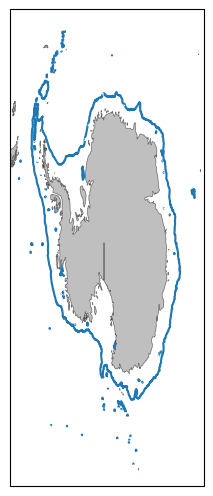

In [86]:
#Creating figure
fig = plt.figure(figsize = (2.5, 9))
#Assigning South Pole Stereographic projection
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())

#Getting land mask with slight transparency
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5, alpha = 0.5)

#Plotting contour and land
base_contour.plot(ax = ax, transform = ccrs.PlateCarree())
ax.add_feature(land)

**Note:** We can see that the continental shelf has been identified correctly. However, there are some smaller polygons inside and outside the shelf polygon that will need to be manually removed before calculating distances to the continental shelf. We did not find a way to automate the identification of the continental shelf in `Python`. Instead, we used [QGIS](https://www.qgis.org/en/site/), an open software geographic information system that allows editing of geospatial data.

# Loading correcting continental shelf contour

In [113]:
corrected_contour = gp.read_file(os.path.join(varDict['base_folder'], 'corrected_shelf_contour.shp'))
corrected_contour

,ID,shelf,geometry
0,16,2.0,"LINESTRING (-25.60000 -73.05454, -25.65000 -73..."
1,17,2.0,"LINESTRING (-24.65000 -72.88370, -24.65000 -72..."
2,21,2.0,"LINESTRING (-24.45000 -72.83488, -24.45000 -72..."
3,27,2.0,"LINESTRING (-23.95000 -72.73726, -23.95000 -72..."
4,28,2.0,"LINESTRING (-19.05000 -71.37050, -19.05000 -71..."
5,30,2.0,"LINESTRING (-18.75000 -71.32169, -18.75000 -71..."
6,35,2.0,"LINESTRING (19.45000 -68.19768, 19.50000 -68.1..."
7,36,2.0,"LINESTRING (-18.25000 -71.27288, -18.25000 -71..."
8,37,2.0,"LINESTRING (20.85000 -68.05124, 20.90000 -68.0..."
9,38,2.0,"LINESTRING (20.15000 -68.00243, 20.20000 -67.9..."


We can see that the corrected shelf contour has about $10\%$ of the rows that the uncorrected contour had. We can plot the result to check the results are correct.

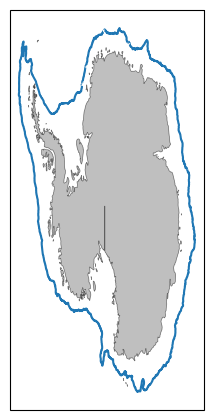

In [114]:
#Checking corrected boundaries
#Creating figure
fig = plt.figure(figsize = (2.5, 9))
#Assigning South Pole Stereographic projection
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())

#Getting land mask with slight transparency
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5, alpha = 0.5)

#Plotting contour and land
corrected_contour.plot(ax = ax, transform = ccrs.PlateCarree())
ax.add_feature(land)

# Calculating distance to closest point along continental shelf grid cell
We will apply the following steps to get the distance from each grid cell to the continental shelf:
1. Get coordinate pairs for all points along the continental shelf,
2. Get coordinate pairs for original dataset to calculate distances to closest shelf point,
3. Use Nearest Neighbour algorithm (`BallTree`) to calculate distance to closest continental shelf,
4. Transform distance from radians to kilometers and store result in a data array,
5. Save output to disk (optional).

## Extracting coordinate pairs for each point along shelf contour

In [129]:
#Empty list to store latitude and coordinate pairs
lon = []
lat = []

#Looping through every row in the shelf contour shapefile
for index, row in corrected_contour.iterrows():
    #Extracting coordinates for each point along each row
    for point in list(row.geometry.coords):
        #Saving coordinates to empty variables
        lon.append(point[0])
        lat.append(point[1])
        
#Create coordinate pairs for each point along the continental shelf break
shelf_coords = np.vstack([lat, lon]).T
shelf_coords

array([[-73.05454171, -25.6       ],
       [-73.03013545, -25.64999985],
       [-73.00572911, -25.6499999 ],
       ...,
       [-73.20097978, -25.6499999 ],
       [-73.17657345, -25.64999985],
       [-73.15216719, -25.6       ]])

## Getting coordinate pairs for each cell in the original grid
We will use the latitude and longitude values in our original data to create coordinate pairs. We will also need to transform coordinate pairs from coordinates to radians as this is needed in the calculation of distances.

In [132]:
#Storing longitude and latitude values
x, y = np.meshgrid(np.deg2rad(cont_1000.x.values),
                   np.deg2rad(cont_1000.y.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T

#Removing variables not needed
del x, y

#Checking result
grid_coords

array([[-1.41561267, -4.88604924],
       [-1.41561267, -4.88430391],
       [-1.41561267, -4.88255858],
       ...,
       [-0.78602773,  1.39190008],
       [-0.78602773,  1.39364541],
       [-0.78602773,  1.39539074]])

## Applying Nearest Neighbour algorithm to calculate distance to closest continental shelf

In [141]:
#Set up Ball Tree. Coordinates must be given in radians
balltree = BallTree(np.deg2rad(shelf_coords), metric = 'haversine')

#Calculate nearest neighbour distances. Function gives two outputs: distances (in radians) and indices
dist_rad, ind = balltree.query(grid_coords, return_distance = True)

## Transforming nearest neighbour distances from radians to kilometers
The `BallTree` algorithm calculates distances in radians, which we will transform into kilometers by multiplying by the Earth's radius in kilometers. We will also store the results in a data array to make any calculations easier.  
  
The new data array will have the same shape as our original `temp` grid.

In [138]:
#Earth radius in km
earth_radius_km = 6371

#Transforming radians and reshaping data
dist_km = xr.DataArray(data = (dist_rad*earth_radius_km).reshape(cont_1000.isel(time = 0).shape),
                           dims = ['yt_ocean', 'xt_ocean'],
                           coords = {'yt_ocean': cont_1000.y.values,
                                     'xt_ocean': cont_1000.x.values},
                           name = 'dist_km')
dist_km = dist_km.assign_attrs({'units': 'km',
                                'long_name': 'distance to nearest neighbour'})

## Plotting results
We will plot the distances calculated in the previous steps with the shelf contour line overlaid on top.

<AxesSubplot:xlabel='xt_ocean', ylabel='yt_ocean'>

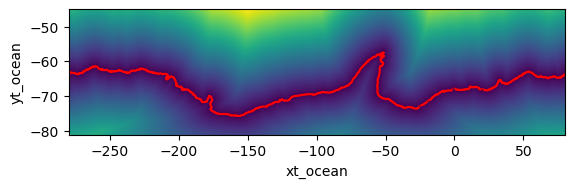

In [153]:
fig, ax = plt.subplots(1, 1)
p1 = dist_km.plot(ax = ax, add_colorbar = False)
corrected_contour.plot(ax = ax, color = 'red')

# Saving results to disk

In [144]:
dist_km.to_netcdf(os.path.join(varDict['base_folder'], 'Corrected_Shelf_Contour.nc'))